<a href="https://colab.research.google.com/github/johanhoffman/DD2365-VT20/blob/LindeBee/Project/projectV4_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [59]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import dolfin.common.plotting as fenicsplot
import math
import scipy.io

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define 3 different domains**

*   4 by 4 perpendicular grid
*   diamond grid
*   Concentric circular grid

2515


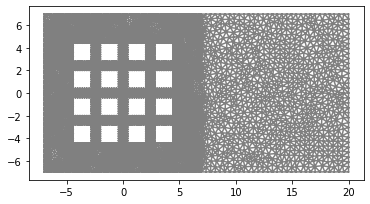

In [61]:
!rm results/*

# Define rectangular domain 
L = 14
H = 14

# import mesh
resolution = 64
mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh_file = File('mesh.xml')
mesh_file >> mesh


# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 0.5:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)


# define source/evaluation area
class SourceGrid(SubDomain):
    def inside(self, x, on_boundary):
        return (x[1]<5.07/cos(alpha) + tan(alpha)*x[0] \
                and x[1]>-5.07/cos(alpha) + tan(alpha)*x[0] \
                and x[0]<5.07/cos(alpha) - tan(alpha)*x[1] and \
                x[0]>-5.07/cos(alpha) - tan(alpha)*x[1])

class SourceSkewed(SubDomain):
    def inside(self, x, on_boundary):
        return (x[1]<5/cos(alpha) + tan(alpha)*x[0] \
                and x[1]>-5/cos(alpha) + tan(alpha)*x[0] \
                and x[0]<5/cos(alpha) - tan(alpha)*x[1] and \
                x[0]>-5/cos(alpha) - tan(alpha)*x[1])

class SourceCircle(SubDomain):
    def inside(self, x, on_boundary):
        return (sqrt(x[0]*x[0]+x[1]*x[1])< 5.5)

alpha = math.radians(0)
source = SourceGrid()
# source = SourceSkewed()
# source = SourceCircle()

domains = MeshFunction("size_t", mesh, mesh.topology().dim())
domains.set_all(0)
source.mark(domains, 1)
cells = domains.array()
n_cells = np.count_nonzero(cells == 1)
print(n_cells)

# for visualisation of different domains
file = File("results/mesh.pvd")
file << domains

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [0]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions 
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [0]:
# # inflow and outflow conditions
XMIN = -7

# Inflow boundary (ib)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())

# **Results**

**Time stepping algorithm**

0.09108420586114817
t: 1.275178882056074
c: 0.11669364246760675


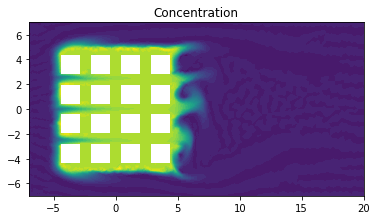

t: 2.5503577641121473
c: 0.21547145910653542


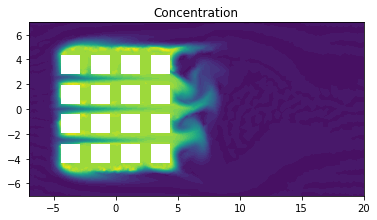

t: 3.8255366461682203
c: 0.29947160810628204


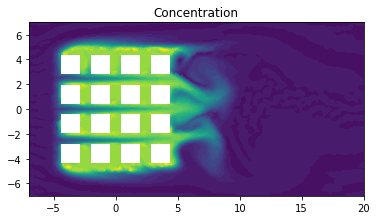

t: 5.009631322363146
c: 0.36903428179149983


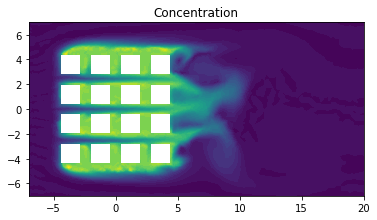

t: 6.284810204419219
c: 0.4382653995355082


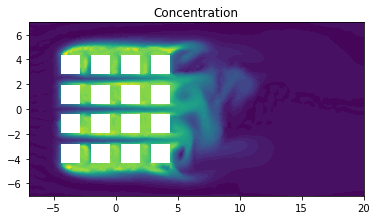

t: 7.559989086475292
c: 0.500697708102034


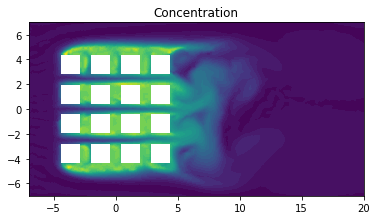

t: 8.835167968531373
c: 0.5572765316631516


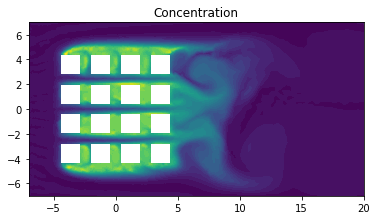

t: 10.01926264472631
c: 0.6070648958760937


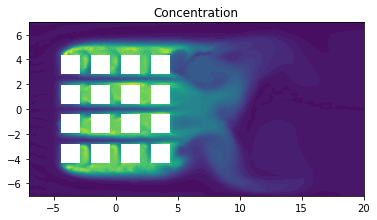

t: 11.294441526782395
c: 0.6578238137231663


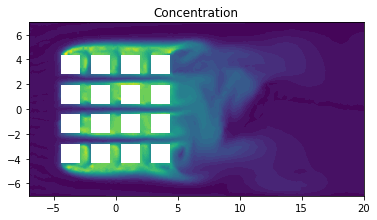

t: 12.56962040883848
c: 0.707971670198596


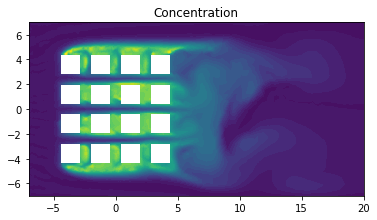

t: 13.753715085033416
c: 0.7490985163020867


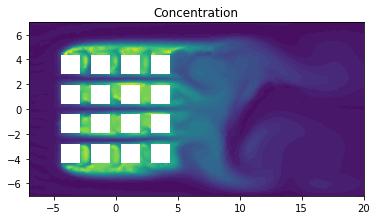

t: 15.028893967089502
c: 0.7904545602447134


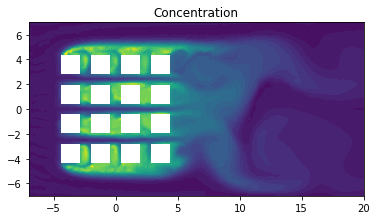

t: 16.30407284914558
c: 0.8299595525993303


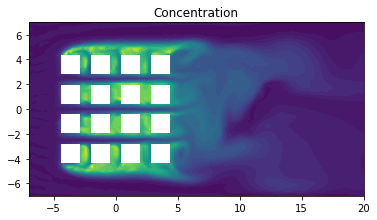

t: 17.57925173120164
c: 0.872799968839502


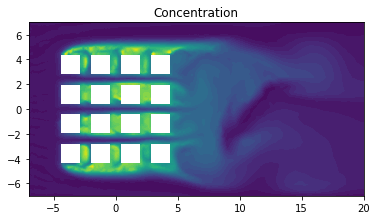

t: 18.763346407396554
c: 0.906011328841024


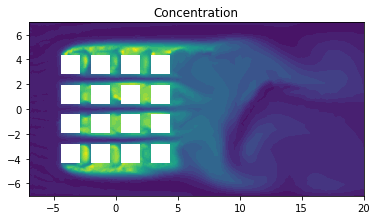

t: 20.038525289452615
c: 0.9386406453259596


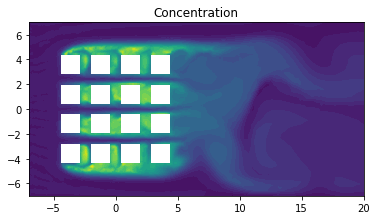

t: 21.313704171508675
c: 0.9702083294808326


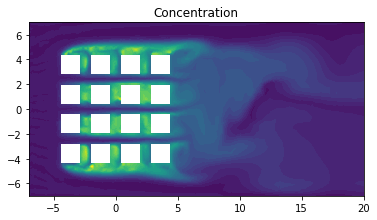

t: 22.588883053564736
c: 1.0078125980646315


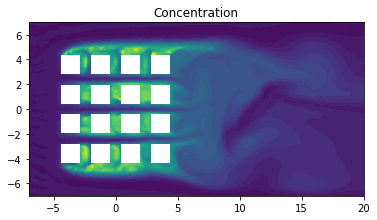

t: 23.77297772975965
c: 1.0350517302223357


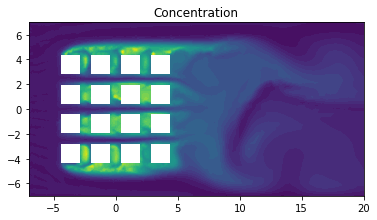

t: 25.04815661181571
c: 1.0611711514322217


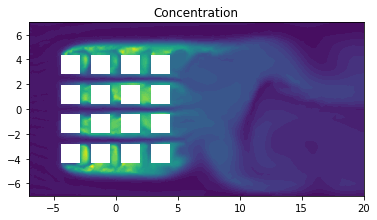

t: 26.32333549387177
c: 1.0867819595606412


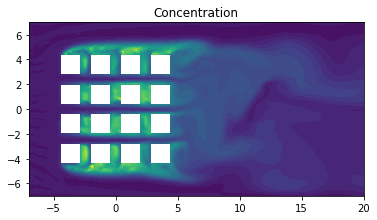

t: 27.507430170066684
c: 1.1179866972656187


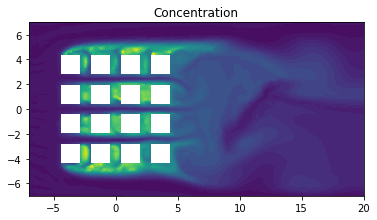

t: 28.782609052122744
c: 1.142810160075642


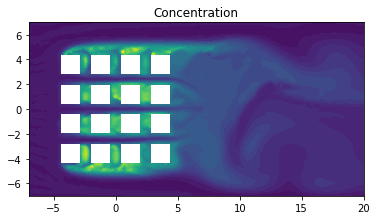

t: 30.057787934178805
c: 1.1638455821012552


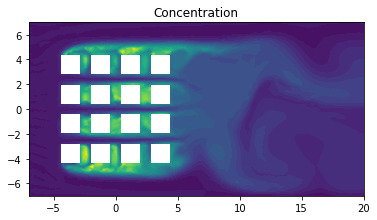

t: 30.057787934178805
c: 1.1638455821012552


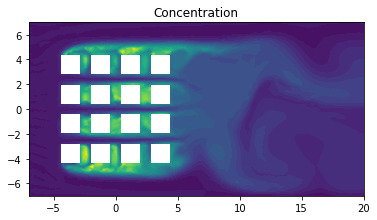

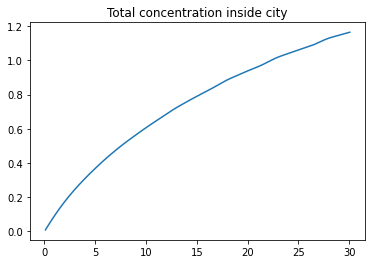

results/
results/u000247.vtu
results/c000288.vtu
results/u000304.vtu
results/c000259.vtu
results/u000164.vtu
results/c.pvd
results/c000056.vtu
results/c000323.vtu
results/c000020.vtu
results/c000194.vtu
results/u000322.vtu
results/u000195.vtu
results/c000051.vtu
results/u000134.vtu
results/u000026.vtu
results/c000326.vtu
results/c000279.vtu
results/u000231.vtu
results/u000157.vtu
results/u000094.vtu
results/c000328.vtu
results/u000243.vtu
results/u000025.vtu
results/c000309.vtu
results/c000062.vtu
results/u000207.vtu
results/c000202.vtu
results/c000112.vtu
results/c000129.vtu
results/c000308.vtu
results/c000230.vtu
results/u000217.vtu
results/c000162.vtu
results/c000123.vtu
results/u000036.vtu
results/u000046.vtu
results/c000006.vtu
results/u000041.vtu
results/c000102.vtu
results/c000273.vtu
results/c000103.vtu
results/u000109.vtu
results/c000010.vtu
results/u000316.vtu
results/c000180.vtu
results/c000241.vtu
results/c000058.vtu
results/c000093.vtu
results/u000159.vtu
results/u000090.v

MessageError: ignored

In [64]:
# Define function space for system of concentrations
u = Function(V)
element = FiniteElement("P", triangle, 1)
Vc = FunctionSpace(mesh, element)

vc = TestFunction(Vc) #test function
# introduce concentration of 1 per second
cin = (0.1/n_cells)*44.8563

# circle
# fc = Expression( "sqrt(x[0]*x[0]+x[1]*x[1])< 5.5 ? cin : 0", cin=cin , element = Vc.ufl_element()) #source
# grid/skewed
fc = Expression( "(x[1]<5.07/cos(alpha) + tan(alpha)*x[0] && x[1]>-5.07/cos(alpha) + tan(alpha)*x[0] && x[0]<5.07/cos(alpha) - tan(alpha)*x[1] && x[0]>-5.07/cos(alpha) - tan(alpha)*x[1]) ? cin : 0", \
                cin=cin, alpha=alpha ,element = Vc.ufl_element()) #source

# fc = Constant(cin)

dt = 0.5*mesh.hmin()  #time step
print(dt)
c = Function(Vc)       #concentration
c_n = Function(Vc)     #concentration previous timestep
d = mesh.hmin()
dx=Measure('dx', domain=mesh, subdomain_data=domains)

h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

#variational problem:
Fc = inner((c-c_n)/dt,vc)*dx + inner(dot(u,grad(c)),vc)*dx \
+ gamma*ib*inner(c,vc)*dx + d*dot(u,grad(c))*dot(u,grad(vc))*dx - fc*vc*dx

#time stepping
file_c = File("results/c.pvd")
file_u = File("results/u.pvd")
timeseries_u = TimeSeries('velocity_series')

t=0
T=30
freq = 24
plot_time = T/freq

c_plot= []
time =[]

while t < T + DOLFIN_EPS:
    # print(n+"\n")
    # Update current time
    t += dt
    # get velocity field
    timeseries_u.retrieve(u.vector(), t%5)
    # Solve variational problem for time step
    solve(Fc == 0, c)
    # Save solution to file (VTK)
    file_c << (c, t)
    file_u << (u, t)
    c_val = assemble(c*dx(1))
    c_plot = np.append(c_plot,c_val)
    time = np.append(time,t)
    # Update previous solution
    c_n.assign(c)

    if t > plot_time: 
      print('t:',t)
      print('c:', c_val)
      plot_time += T/freq
      c1 = project(c, Vc)
      plt.figure()
      plot(c1, title="Concentration")
      plt.show()
      
# Plot solution
print('t:',t)
print('c:', c_val)

c1 = project(c, Vc)
plt.figure()
plot(c1, title="Concentration")
plt.show()

plt.figure()
plt.plot(time, c_plot)
plt.title("Total concentration inside city")
plt.show()

arr = np.append(np.matrix(time), np.matrix(c_plot),axis =0).T
scipy.io.savemat('results/arrdata.mat', mdict={'arr': arr})

!tar -czvf results.tar.gz results
files.download('results.tar.gz')


# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street)